In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import sys
import requests as req
import json

from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor

Adding /root/curve-lp-metrics to sys.path


In [13]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [15]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
for p in pool_metadata:
    pool_metadata[p]['inputTokens'] = json.loads(pool_metadata[p]['inputTokens'])

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-03-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-03-15"))

In [16]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)

In [40]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)
pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)

['0x6b175474e89094c44da98b954eedeac495271d0f', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xdac17f958d2ee523a2206206994597c13d831ec7']


TypeError: list indices must be integers or slices, not str

In [8]:
pool_data['approxTimestamp'] = pool_data['block'].apply(lambda x: datahandler.get_block_timestamp(x)[0]['timestamp'])
pool_data.index = pool_data['approxTimestamp'].apply(datetime.fromtimestamp)
pool_data.head()

,id,pool_id,block,totalValueLockedUSD,inputTokenBalances,inputTokenWeights,approxTimestamp,outputTokenSupply
approxTimestamp,,,,,,,,
2023-02-01 00:00:11,26230078,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16530248,5.446427e+08,"[195893429813855888940119779, 189915532290792,...","[35.136780360113306, 34.064543927871796, 30.79...",1675209611,5.446427e+26
2023-02-01 00:00:23,26318496,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16530249,5.446427e+08,"[195893429813855888940119779, 189915532290792,...","[35.136780360113306, 34.064543927871796, 30.79...",1675209623,5.446427e+26
2023-02-01 00:00:35,26318498,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16530250,5.446427e+08,"[195893429813855888940119779, 189915532290792,...","[35.136780360113306, 34.064543927871796, 30.79...",1675209635,5.446427e+26
2023-02-01 00:00:47,26318429,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16530251,5.446427e+08,"[195893429813855888940119779, 189915532290792,...","[35.136780360113306, 34.064543927871796, 30.79...",1675209647,5.446427e+26
2023-02-01 00:00:59,26318451,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16530252,5.446427e+08,"[195893429813855888940119779, 189915532290792,...","[35.136780360113306, 34.064543927871796, 30.79...",1675209659,5.446427e+26


<Axes: xlabel='approxTimestamp'>

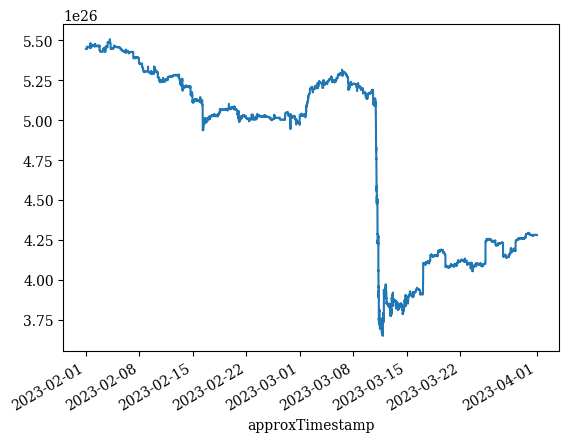

In [9]:
pool_data['outputTokenSupply'].plot()

In [ ]:
async def get_snapshots():
    datafetcher = DataFetcher(token_metadata=token_metadata)
    try:
        snapshots = datafetcher.get_snapshots(start_ts, end_ts, pool)
    except Exception as e:
        print(f'excepted: {e}')
        return 
    finally:
        await datafetcher.close()
    return snapshots
    
snapshots = await get_snapshots()

In [ ]:
df = pd.DataFrame.from_dict([x for y in snapshots for x in y])
for col in ['A', 'offPegFeeMultiplier', 'timestamp', 'virtualPrice', 'lastPricesTimestamp', 'block_gte', 'block_lt']:
    df[col] = df[col].astype(int)
for col in ['adminFee', 'fee', 'lpPriceUSD', 'tvl', 'totalDailyFeesUSD', 'lpFeesUSD']:
    df[col] = df[col].astype(float)
for col in ['normalizedReserves', 'reserves']:
    df[col] = df[col].apply(lambda x: [int(y) for y in x])
for col in ['reservesUSD']:
    df[col] = df[col].apply(lambda x: [float(y) for y in x])
df = df.sort_values(by='timestamp')
df.index = df['timestamp'].apply(datetime.fromtimestamp)
df.head()

,A,adminFee,fee,id,normalizedReserves,offPegFeeMultiplier,reserves,timestamp,virtualPrice,lpPriceUSD,tvl,totalDailyFeesUSD,reservesUSD,lpFeesUSD,lastPricesTimestamp,lastPrices,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,,,,,,,,,
2023-01-02,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[148938208479777840628060026, 1599824687740060...",0,"[148938208479777840628060026, 159982468774006,...",1672617600,1023152250199149802,1.023133,6.105893e+08,5582.998422,"[148932205.91953325, 159959328.19540858, 30169...",2791.499211,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1672531211,1672617611
2023-01-03,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[159572453684743356897318979, 1786970667509620...",0,"[159572453684743356897318979, 178697066750962,...",1672704000,1023156528630158615,1.023109,6.119763e+08,5106.501360,"[159566415.03561744, 178665926.428248, 2737439...",2553.250680,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1672617611,1672704011
2023-01-04,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[165890887651851960179247378, 1684198888643700...",0,"[165890887651851960179247378, 168419888864370,...",1672790400,1023171168848835320,1.023117,6.069722e+08,17513.384250,"[165868610.4015682, 168401428.60072362, 272702...",8756.692125,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1672704011,1672790411
2023-01-05,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[166436226970205286293001215, 1807302324258550...",0,"[166436226970205286293001215, 180730232425855,...",1672876800,1023184150121970187,1.023130,6.111978e+08,15401.669440,"[166425352.11910185, 180702225.5386556, 264070...",7700.834720,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1672790411,1672876811
2023-01-06,2000,0.0,0.0001,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7-167...,"[165567141279159392862837397, 1623411985793900...",0,"[165567141279159392862837397, 162341198579390,...",1672963200,1023201486251684292,1.023166,6.085881e+08,20711.431933,"[165553256.53297555, 162323265.1015526, 280711...",10355.715967,0,0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,1672876811,1672963211


<Axes: xlabel='timestamp'>

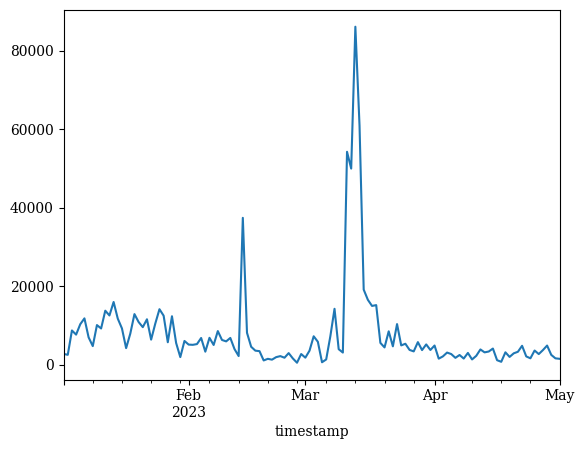

In [ ]:
df['lpFeesUSD'].plot()

In [ ]:
pool_df = pool_data[['totalValueLockedUSD', 'inputTokenBalances', 'outputTokenSupply']]
pool_df.head()

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply
approxTimestamp,,,
2023-01-01 00:00:11,5.959284e+08,"[152704148748632910687719078, 153704487130009,...",5.959284e+26
2023-01-01 00:00:23,5.959284e+08,"[152704148748632910687719078, 153704487130009,...",5.959284e+26
2023-01-01 00:00:35,5.959284e+08,"[152704148748632910687719078, 153704487130009,...",5.959284e+26
2023-01-01 00:00:47,5.959284e+08,"[152704148748632910687719078, 153704487130009,...",5.959284e+26
2023-01-01 00:00:59,5.959284e+08,"[152704148748632910687719078, 153704487130009,...",5.959284e+26


In [ ]:
lp_data.index = lp_data['timestamp'].apply(datetime.fromtimestamp)
lp_data.head()

,id,block,liquidityProvider,removal,timestamp,tokenAmounts,totalSupply,tx,pool_id,block_gte,block_lt
timestamp,,,,,,,,,,,
2023-01-01 00:02:11,0x7aff4dd1c0bd6bd5180f08d9c2b9e78c482a2d8d8e03...,16308200,0xa77d09743f77052950c4eb4e6547e9665299becd,1,1672531331,"[0, 0, 50797831]",5.959284e+26,0x7aff4dd1c0bd6bd5180f08d9c2b9e78c482a2d8d8e03...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16308195,16308205
2023-01-01 00:04:11,0x5e24bcbfc2dcf88784aa4e2fdccb61342f9ec2b59f85...,16308210,0x99a58482bd75cbab83b27ec03ca68ff489b5788f,1,1672531451,"[0, 3827008267, 0]",5.959246e+26,0x5e24bcbfc2dcf88784aa4e2fdccb61342f9ec2b59f85...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16308205,16308215
2023-01-01 00:08:47,0x42bb3eadc3fd9006297105ac6a519cf3d5bf029c4f44...,16308233,0xd70bd78a9132214bc8a8343dd7ad68cc4b7e994d,1,1672531727,"[0, 24459383, 0]",5.959246e+26,0x42bb3eadc3fd9006297105ac6a519cf3d5bf029c4f44...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16308225,16308235
2023-01-01 00:17:23,0xfd63ddf85d8b9f9c08644945b58788a3eeb80cc58fc1...,16308275,0xc2a54f74ebbbba5ed92d6a0b5dcb0b0ffb96f36e,0,1672532243,"[0, 22038083584, 0]",5.959462e+26,0xfd63ddf85d8b9f9c08644945b58788a3eeb80cc58fc1...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16308275,16308285
2023-01-01 00:17:47,0x1c14c8271faa30fccb07b000cbb977399f270b543748...,16308277,0x5a6a4d54456819380173272a5e8e9b9904bdf41b,1,1672532267,"[0, 9989021924, 0]",5.959364e+26,0x1c14c8271faa30fccb07b000cbb977399f270b543748...,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,16308275,16308285


In [14]:
def calc_virtual_price(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)/(row['outputTokenSupply'])
def calc_sum_reserves(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)

pool_df['virtualPrice'] = pool_df.apply(calc_virtual_price, axis=1)
pool_df['sumReserves'] = pool_df.apply(calc_sum_reserves, axis=1)
pool_df

ValueError: too many values to unpack (expected 2)

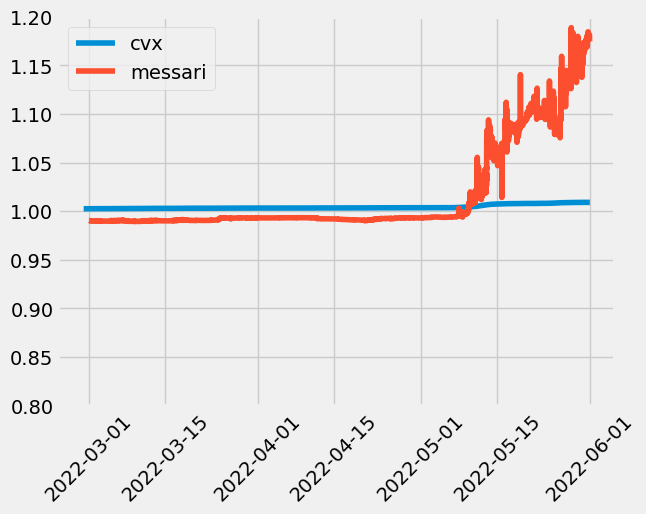

In [ ]:
f, ax = plt.subplots()
ax.plot(df.index, df['virtualPrice']/1e18, label='cvx')
ax.plot(pool_df.index, pool_df['virtualPrice'], label='messari')
ax.set_ylim(0.8, 1.2)
ax.legend()
ax.tick_params(axis='x', rotation=45)

In [ ]:
ust = '0xa693b19d2931d498c5b318df961919bb4aee87a5'
ust_ohlcv = datahandler.get_ohlcv_data(ust, start=start_ts, end=end_ts)
ust_ohlcv = ust_ohlcv['close']
ust_ohlcv.name = token_metadata[ust]['symbol']
ust_ohlcv.head()

timestamp
2022-02-28 00:01:00    1.004
2022-02-28 00:02:00    1.004
2022-02-28 00:03:00    1.004
2022-02-28 00:04:00    1.004
2022-02-28 00:05:00    1.004
Freq: T, Name: UST, dtype: float64

In [ ]:
final_df = pool_df.resample('1min').last()
final_df = pd.merge(final_df, ust_ohlcv, how='left', left_index=True, right_index=True).fillna(method='ffill').fillna(method='bfill')
final_df['3Crv'] = 1
final_df.head()

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply,virtualPrice,sumReserves,UST,3Crv
approxTimestamp,,,,,,,
2022-02-27 23:46:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.004,1
2022-02-27 23:47:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.004,1
2022-02-27 23:48:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.004,1
2022-02-27 23:49:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.004,1
2022-02-27 23:50:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.004,1


In [ ]:
def calc_real_price(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    crv_value = crv_balance * row['3Crv']
    ust_value = ust_balance * row['UST']
    return (crv_value + ust_value * 1e12)/(row['outputTokenSupply'])
def calc_real_value(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    crv_value = crv_balance * row['3Crv']
    ust_value = ust_balance * row['UST']
    return (crv_value + ust_value * 1e12)

final_df['realPrice'] = final_df.apply(calc_real_price, axis=1)
final_df['realValue'] = final_df.apply(calc_real_value, axis=1)
final_df

,totalValueLockedUSD,inputTokenBalances,outputTokenSupply,virtualPrice,sumReserves,UST,3Crv,realPrice,realValue
approxTimestamp,,,,,,,,,
2022-02-27 23:46:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.00400,1,0.988635,1.151961e+27
2022-02-27 23:47:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.00400,1,0.988635,1.151961e+27
2022-02-27 23:48:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.00400,1,0.988635,1.151961e+27
2022-02-27 23:49:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.00400,1,0.988635,1.151961e+27
2022-02-27 23:50:00,1.189813e+09,"[729602966560417887437631762, 420675648975802]",1.165204e+27,0.99048,1.150279e+27,1.00400,1,0.988635,1.151961e+27
...,...,...,...,...,...,...,...,...,...
2022-05-31 23:56:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.17423,1.014900e+25,0.03289,1,0.041717,3.605615e+23
2022-05-31 23:57:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.17423,1.014900e+25,0.03289,1,0.041717,3.605615e+23
2022-05-31 23:58:00,8.912340e+06,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.17423,1.014900e+25,0.03289,1,0.041717,3.605615e+23


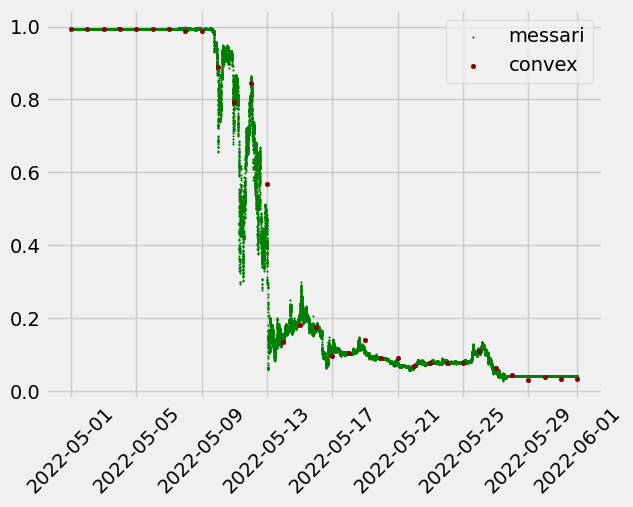

In [ ]:
messari = final_df['realPrice'].loc['2022-05-01':]
convex = df['lpPriceUSD'].loc['2022-05-01':]

f, ax = plt.subplots()

ax.scatter(messari.index, messari, label='messari', c='green', s=1)
ax.scatter(convex.index, convex, label='convex', c='darkred', s=10, zorder=10)
ax.legend()
ax.tick_params(axis='x', rotation=45)
f.show()

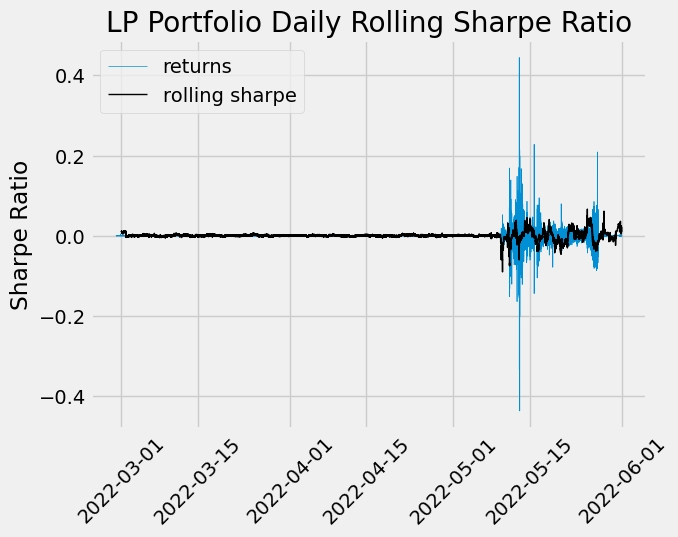

In [ ]:
f, ax = plt.subplots()
periods = 60*24
cumulative_returns = final_df['realPrice'].pct_change()
rolling_sharpe = cumulative_returns.rolling(periods).mean() / cumulative_returns.rolling(periods).std()
ax.plot(cumulative_returns.index, cumulative_returns, label='returns', linewidth=0.5)
ax.plot(rolling_sharpe.index, rolling_sharpe, label='rolling sharpe', linewidth=1, c='black')
ax.legend()
ax.set_title('LP Portfolio Daily Rolling Sharpe Ratio')
ax.set_ylabel('Sharpe Ratio')
ax.tick_params(axis='x', rotation=45)

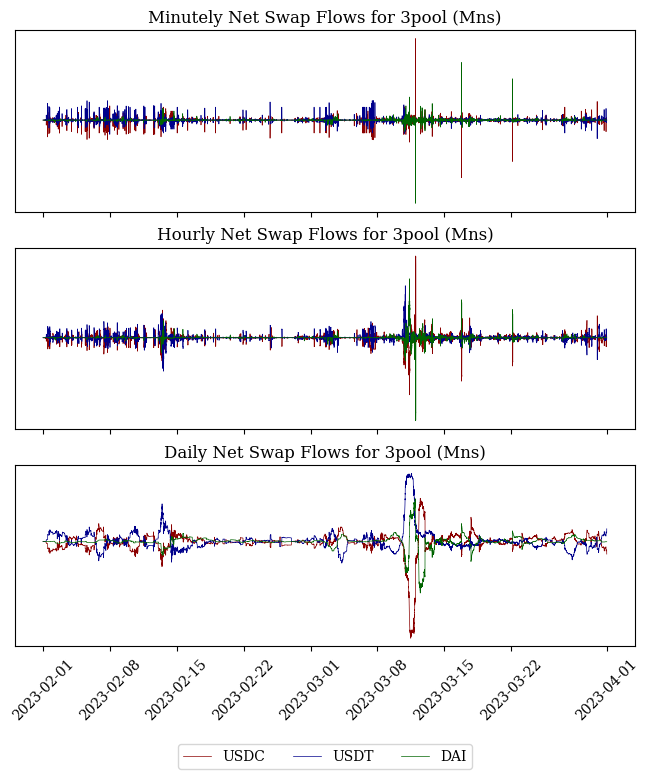

In [13]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('./figs/3pool_swap_flows.png', bbox_inches='tight')

In [83]:
import numpy as np
from multiprocessing import Pool, cpu_count
from statsmodels.tsa.stattools import adfuller

def rolling_adfuller_chunk(chunk):
    window, X_chunk = chunk
    results = np.empty(len(X_chunk), dtype='object')
    dates = np.empty(len(X_chunk), dtype='datetime64[s]')
    for i in range(window, len(X_chunk)):
        window_data = X_chunk[i-window:i]
        result = adfuller(window_data)
        results[i] = result
        dates[i] = X_chunk.index[i]
    return pd.Series(results, index=dates)

def rolling_adfuller_parallel(X, window):
    chunks = np.array_split(X, cpu_count())
    chunks = [(window, chunk) for chunk in chunks]
    with Pool(cpu_count()) as p:
        results = p.map(rolling_adfuller_chunk, chunks)
    return results

<Axes: xlabel='timestamp'>

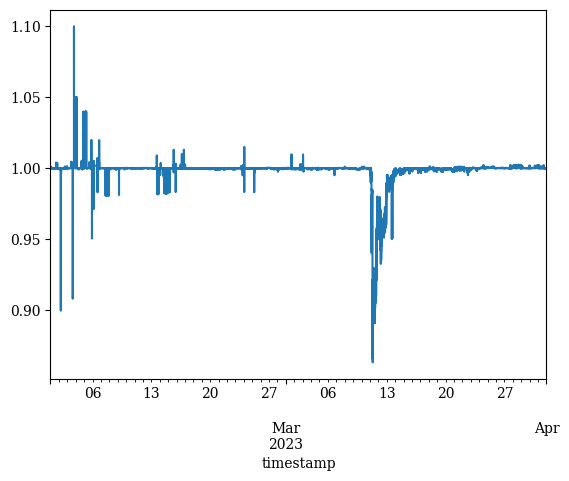

In [47]:
usdc = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
usdc_ohlcv = datahandler.get_ohlcv_data(usdc, start=start_ts, end=end_ts)
usdc_ohlcv = usdc_ohlcv['close']
usdc_ohlcv.name = token_metadata[usdc]['symbol']
usdc_ohlcv.plot()

In [84]:
prices = usdc_ohlcv.loc['2023-02-15':'2023-03-25'].resample('15min').last()

adf_res = rolling_adfuller_parallel(prices, 24*4)

adf_res

# signals = [int(r[1] < 0.05) for r in adf_res]

# f, ax = plt.subplots()

# ax.plot(dates, signals)

# ax.tick_params(axis='x', rotation=45)

[4446757-08-17 04:52:48                                                 None
 4446757-08-17 04:52:48                                                 None
 3006945-01-12 15:33:52                                                 None
 3006945-01-12 15:33:52                                                 None
 26412-11-11 14:06:56                                                   None
                                                 ...                        
 2023-03-06 10:45:00       (-7.773049117116866, 8.816223437911084e-12, 0,...
 2023-03-06 11:00:00       (-7.739086556741001, 1.0738786542956656e-11, 0...
 2023-03-06 11:15:00       (-7.77983118042376, 8.475468772518125e-12, 0, ...
 2023-03-06 11:30:00       (-7.779831180423745, 8.475468772518928e-12, 0,...
 2023-03-06 11:45:00       (-7.779831180423727, 8.475468772519728e-12, 0,...
 Length: 1872, dtype: object,
 4446757-08-17 04:52:48                                                 None
 4446757-08-17 04:52:48                       

In [ ]:
returns = np.log(usdc_ohlcv.pct_change())
returns.plot()

In [ ]:
adf_res, dates = rolling_adfuller(returns, 24*10)
signals = [int(r[1] < 0.05) for r in adf_res]
f, ax = plt.subplots()
ax.plot(dates, signals)
ax.tick_params(axis='x', rotation=45)

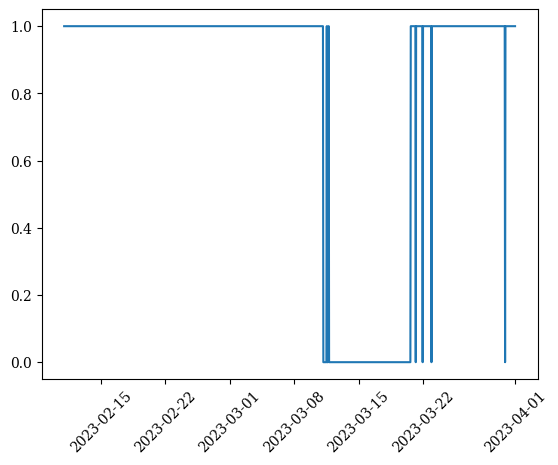

In [45]:
adf_res, dates = rolling_adfuller(prices, 24*10)

signals = [int(r[1] < 0.05) for r in adf_res]

f, ax = plt.subplots()

ax.plot(dates, signals)

ax.tick_params(axis='x', rotation=45)

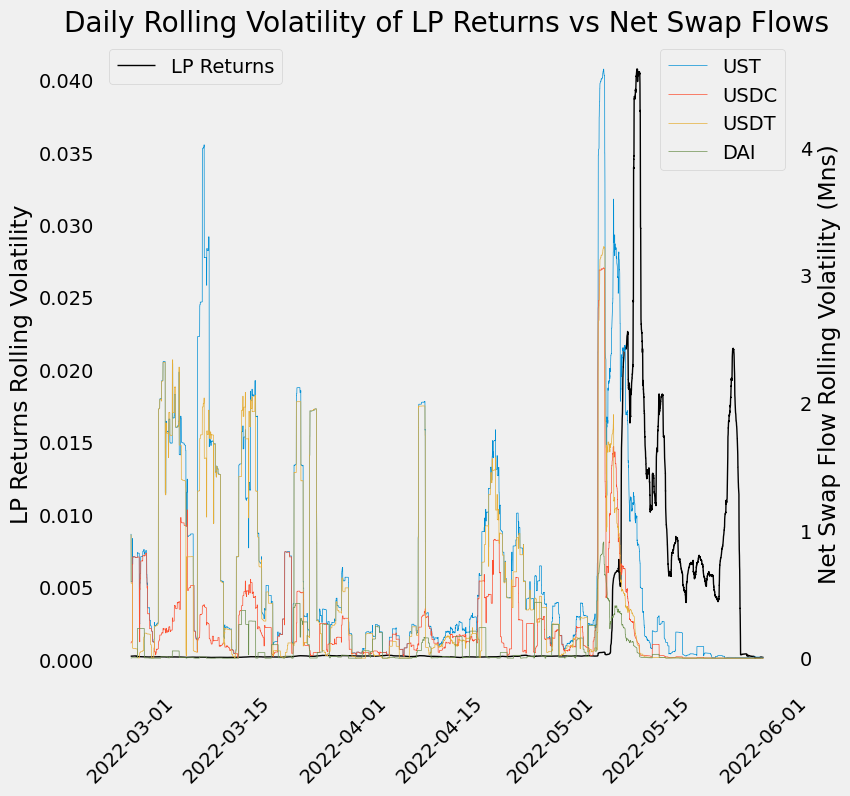

In [24]:
f, ax = plt.subplots(figsize=(8,8))
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.netSwapFlow'].rolling(periods).std()/1e6
usdc_rolling_std = pool_metrics['USDC.netSwapFlow'].rolling(periods).std()/1e6
usdt_rolling_std = pool_metrics['USDT.netSwapFlow'].rolling(periods).std()/1e6
dai_rolling_std = pool_metrics['DAI.netSwapFlow'].rolling(periods).std()/1e6

ax.plot(return_variance.index, return_variance, label='LP Returns', c='black', linewidth=1)
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST', linewidth=0.5)
ax2.plot(usdc_rolling_std.index, usdc_rolling_std, label='USDC', linewidth=0.5)
ax2.plot(usdt_rolling_std.index, usdt_rolling_std, label='USDT', linewidth=0.5)
ax2.plot(dai_rolling_std.index, dai_rolling_std, label='DAI', linewidth=0.5)
ax.grid(False)
ax2.grid(False)
ax.set_ylabel('LP Returns Rolling Volatility')
ax2.set_ylabel('Net Swap Flow Rolling Volatility (Mns)')
ax.set_title(f'Daily Rolling Volatility of LP Returns vs Net Swap Flows')
ax.legend()
ax2.legend()
ax.tick_params(axis='x', rotation=45)

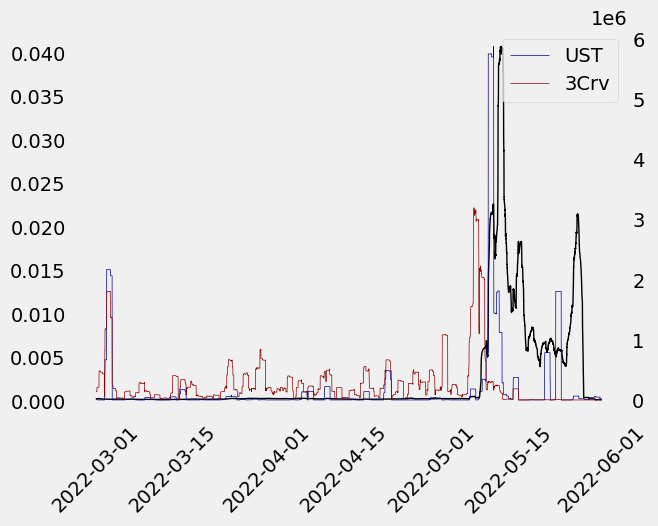

In [57]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.netLPFlow'].rolling(periods).std()/1e6
crv_rolling_std = pool_metrics['3Crv.netLPFlow'].rolling(periods).std()/1e18
ax.plot(return_variance.index, return_variance, label='returns', linewidth=1, c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST', linewidth=0.5, c='darkblue')
ax2.plot(crv_rolling_std.index, crv_rolling_std, label='3Crv', linewidth=0.5, c='darkred')
ax.grid(False)
ax2.grid(False)
ax2.legend()
ax.tick_params(axis='x', rotation=45)

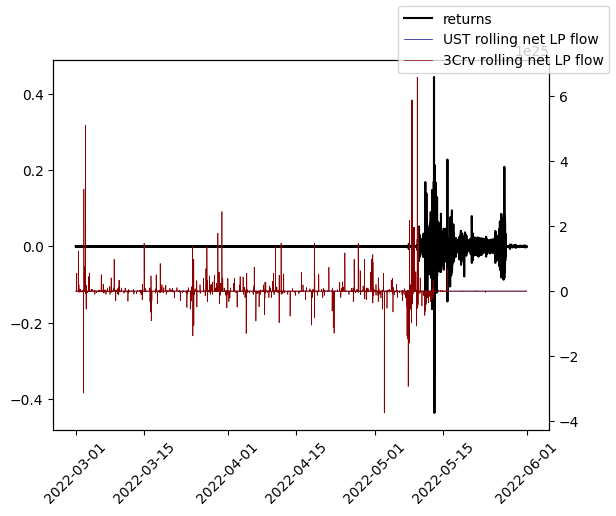

In [25]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change()
ust_rolling_std = pool_metrics['UST.netLPFlow']
crv_rolling_std = pool_metrics['3Crv.netLPFlow']
ax.plot(return_variance.index, return_variance, label='returns', c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST rolling net LP flow', linewidth=0.5, c='darkblue')
ax2.plot(crv_rolling_std.index, crv_rolling_std, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)

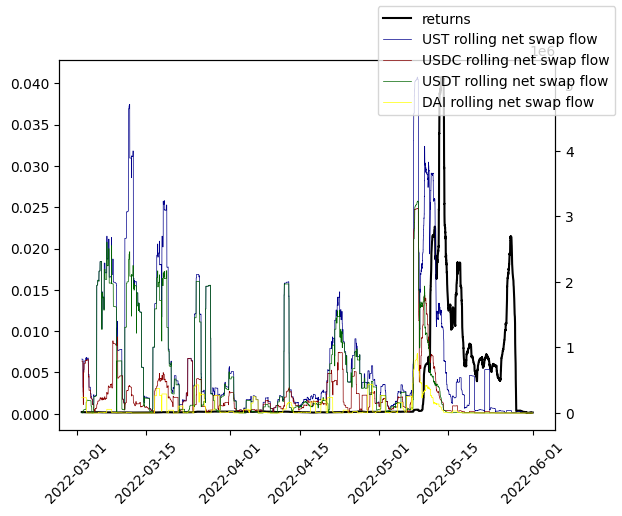

In [26]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice'].pct_change().rolling(periods).std()
ust_rolling_std = pool_metrics['UST.absSwapFlow'].rolling(periods).std()
usdc_rolling_std = pool_metrics['USDC.absSwapFlow'].rolling(periods).std()
usdt_rolling_std = pool_metrics['USDT.absSwapFlow'].rolling(periods).std()
dai_rolling_std = pool_metrics['DAI.absSwapFlow'].rolling(periods).std()
ax.plot(return_variance.index, return_variance, label='returns', c='black')
ax2.plot(ust_rolling_std.index, ust_rolling_std, label='UST rolling net swap flow', linewidth=0.5, c='darkblue')
ax2.plot(usdc_rolling_std.index, usdc_rolling_std, label='USDC rolling net swap flow', linewidth=0.5, c='darkred')
ax2.plot(usdt_rolling_std.index, usdt_rolling_std, label='USDT rolling net swap flow', linewidth=0.5, c='darkgreen')
ax2.plot(dai_rolling_std.index, dai_rolling_std, label='DAI rolling net swap flow', linewidth=0.5, c='yellow')
f.legend()
ax.tick_params(axis='x', rotation=45)

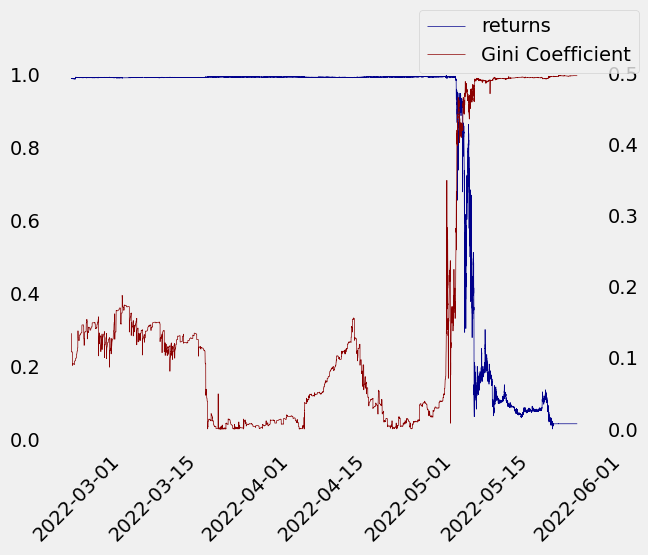

In [78]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
returns = final_df['realPrice']
gini_coefficient = pool_metrics['giniCoefficient']
ax.plot(returns.index, returns, label='returns', linewidth=0.5, c='darkblue')
ax2.plot(gini_coefficient.index, gini_coefficient, label='Gini Coefficient', linewidth=0.5, c='darkred')
ax.grid(False)
ax2.grid(False)
f.legend()
ax.tick_params(axis='x', rotation=45)

In [ ]:
series_a = usdc_flow.loc['2022-03-01':]
series_b = returns.loc['2022-03-01':]
lags = list(range(-60*24, 60*24))

# Compute the cross-correlation
cross_corr = compute_lagged_corr(series_a, series_b, lags)

f, ax = plt.subplots()

ax.scatter(lags, cross_corr)

In [32]:
tokens = set(swaps_data['tokenBought']).union(set(swaps_data['tokenSold']))
ohlcvs = {}
ignore = set(['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490']) # metapool, ignore LP token for now
tokens -= ignore
for token in tokens:
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start_ts, end_ts)

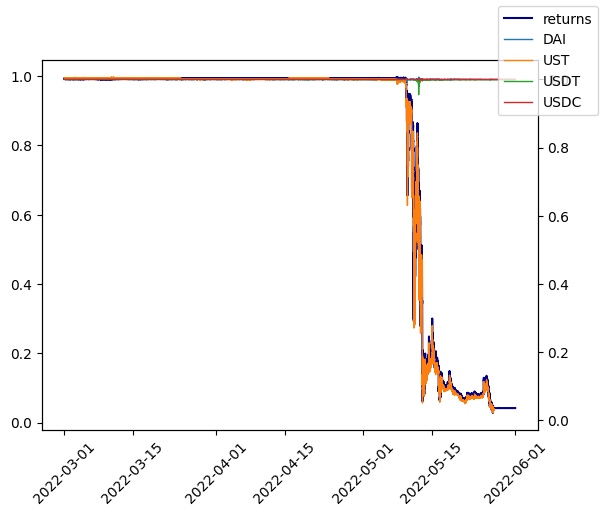

In [37]:
f, ax = plt.subplots()
ax2 = ax.twinx()
periods = 60*24
return_variance = final_df['realPrice']
for token in tokens:
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], label=token_metadata[token]['symbol'], linewidth=1)
ax.plot(return_variance.index, return_variance, label='returns', c='darkblue')
f.legend()
ax.tick_params(axis='x', rotation=45)

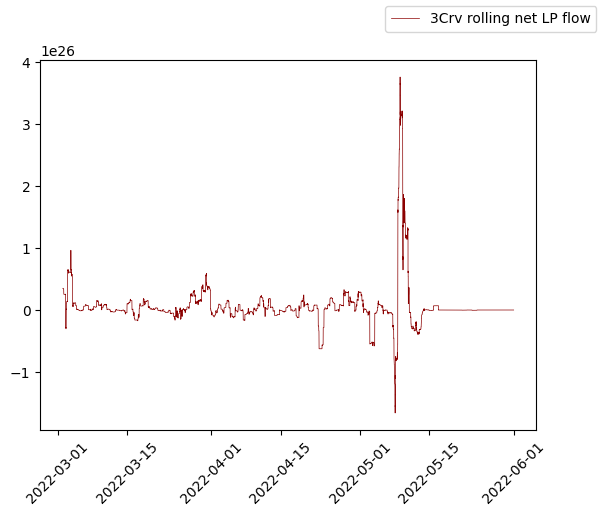

In [54]:
f, ax = plt.subplots()
foo = pool_metrics['3Crv.netLPFlow'].rolling(periods).sum()
ax.plot(foo.index, foo, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)

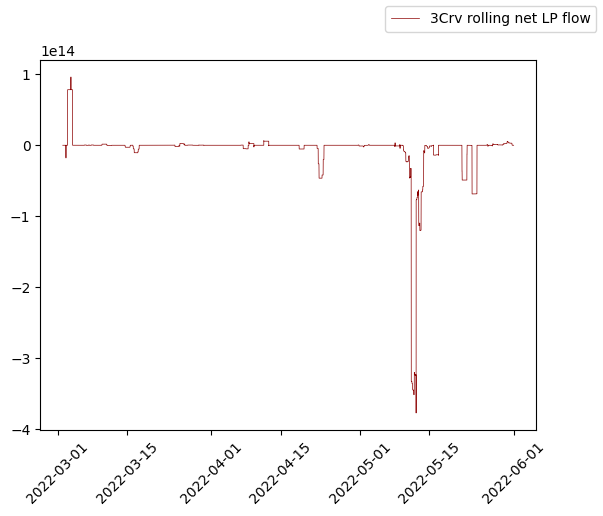

In [55]:
f, ax = plt.subplots()
foo = pool_metrics['UST.netLPFlow'].rolling(periods).sum()
ax.plot(foo.index, foo, label='3Crv rolling net LP flow', linewidth=0.5, c='darkred')
f.legend()
ax.tick_params(axis='x', rotation=45)

In [54]:
from detecta import detect_cusum

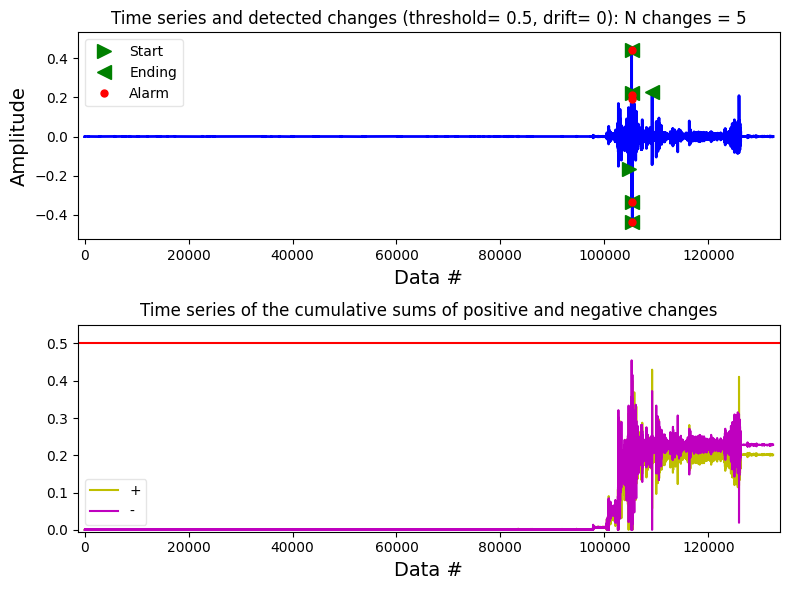

(array([105253, 105261, 105263, 105376, 105377]),
 array([104668, 105253, 105261, 105264, 105376]),
 array([105253, 105261, 105264, 105376, 109193]),
 array([ 0.60913063, -0.77885466,  0.55869798, -0.6616973 ,  0.66525751]))

In [57]:
detect_cusum(final_df['realPrice'].pct_change().dropna(), threshold=0.5, ending=True, show=True)